<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/2_first_classifier_LASR_PARAGRAPH_ONLY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding + first classifier

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold,train_test_split,cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler


In [2]:
data = pd.read_csv("dca_for_classifier.csv")

In [3]:
# ביטוי לבדיקה
keyword = "העותק כפוף לשינויי עריכה וניסוח"

# בדיקה אילו שורות מכילות את הביטוי
rows_with_keyword = data["גוף המסמך"].str.contains(keyword, na=False)

# סינון שורות שלא מכילות את הביטוי
filtered_data = data[rows_with_keyword]

# הדפסת השורות שלא מכילות את הביטוי
rows_without_keyword = data[~rows_with_keyword]
print("שורות שלא מכילות את הביטוי:\n")
print(rows_without_keyword["גוף המסמך"].to_string(index=False))

# הדפסת מספר השורות שנמחקו
num_removed = len(rows_without_keyword)
print(f"\nמספר השורות שנמחקו: {num_removed}")

# שמירת הנתונים המסוננים לקובץ חדש
filtered_data.to_csv("filtered_data.csv", index=False, encoding='utf-8')
print("\nהנתונים המסוננים נשמרו לקובץ: 'filtered_data.csv'")

data = filtered_data

שורות שלא מכילות את הביטוי:

['פסק-דין בתיק רע"פ 7861/03 בבית המשפט העליון ר...
['פסק-דין בתיק רע"פ 2038/04 בבית המשפט העליון ר...
['פסק-דין בתיק רע"פ 5978/04 בבית המשפט העליון ר...

מספר השורות שנמחקו: 3

הנתונים המסוננים נשמרו לקובץ: 'filtered_data.csv'


In [4]:
data

,גוף המסמך,מספר תיק,Outcome of case,binary_outcome
1,"['פסק-דין בתיק רע""פ 8337/04 בבית המשפט העליון ...",8337/04,G R,1.0
2,"['החלטה בתיק רע""פ 7896/04 בבית המשפט העליון רע...",7896/04,G A,1.0
5,"['החלטה בתיק רע""פ 2985/04 בבית המשפט העליון בי...",2985/04,G A,1.0
6,"['החלטה בתיק רע""פ 110/04 בבית המשפט העליון רע""...",110/04,G A,1.0
7,"['פסק דין בתיק רע""פ 2929/04 בבית המשפט העליון ...",2929/04,G R substential matter that was resolved with ...,1.0
...,...,...,...,...
726,"['החלטה בתיק רע""פ 3076/07 בבית המשפט העליון רע...",3076/07,D,0.0
727,"['החלטה בתיק רע""פ 6415/07 בבית המשפט העליון רע...",6415/07,D A,0.0
728,"['החלטה בתיק רע""פ 825/07 בבית המשפט העליון רע""...",825/07,D A,0.0
729,"['החלטה בתיק רע""פ 4180/07 בבית המשפט העליון רע...",4180/07,D A,0.0


binary_outcome
0.0    680
1.0     43
Name: count, dtype: int64


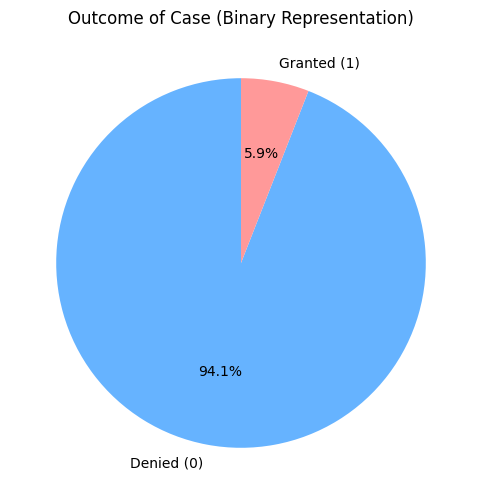

In [5]:
binary_counts = data['binary_outcome'].value_counts()
print(binary_counts)
labels = ['Denied (0)','Granted (1)']

plt.figure(figsize=(6, 6))
plt.pie(binary_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Outcome of Case (Binary Representation)')

plt.show()

In [6]:
# הגדרת פונקציה לעיצוב טקסט
def format_text(text, line_length=80):
    """
    פורמט טקסט כך שיהיה נוח לקריאה עם שורות שאורכן מוגבל.
    """
    import textwrap
    return "\n".join(textwrap.wrap(text, width=line_length))


In [7]:

tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    # המרת הטקסט לפורמט מתאים למודל
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # חישוב האימבדינג של המודל
    outputs = model(**inputs)
    # חישוב ממוצע הוקטורים עבור כל טקסט
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

## Only last paragraph modeling


In [9]:
500 - 50

450

In [10]:
# פונקציה לחיתוך הטקסט בהתאם לכללים
def trim_text(text):
    min_length = 500  # אורך מינימלי לשמירה
    last_sen = 50     # מספר תווים להסרה מסוף הטקסט

    # שמירת אורך מקורי לאבחון
    original_length = len(text)

    # הסרת מספר תווים מסוף הטקסט
    text = text[:-last_sen]

    # חיתוך ל-min_length האחרונים אם הטקסט ארוך יותר מהמינימום
    if len(text) > min_length:
        text = text[-min_length:]

    # הדפסת פידבק רק אם הטקסט עבר שינוי
    if len(text) != original_length:
        print(f"Trimmed Text (Original Length: {original_length}, Trimmed Length: {len(text)}):")
        formatted_text = "\n".join([text[i:i+80] for i in range(0, len(text), 80)])
        print(formatted_text)
        print("##*******************************************************####")
    return text


# הסרת שורות עם ערכים חסרים בעמודת הטקסט או בעמודת המטרה
data = data.dropna(subset=["גוף המסמך", "binary_outcome"])

# חיתוך הטקסטים בעמודת "גוף המסמך"
data["גוף המסמך"] = data["גוף המסמך"].apply(trim_text)

# שמירת התוצאה לקובץ
file_path = 'final_trimmed_data.csv'
data.to_csv(file_path, index=False, encoding='utf-8')

print(f"הקובץ נשמר בהצלחה בנתיב: {file_path}")


Streaming output truncated to the last 5000 lines.
##*******************************************************####
Trimmed Text (Original Length: 4724, Trimmed Length: 500):
ם מקצועי אשר יוכל לסייע לו להיגמלנזקפת בהחלט לחובתו ואין לו על מי להלין, אם הוא 
עצמו אינו מוכן לעשות את הצעדהראשון, על-מנת לחלץ את עצמו ממצב ההתמכרות בו הוא שרו
י. אשר-על-כן, הבקשה למתן רשות ערעור נדחית. החלטתי מיום 22.5.06 - בעניין עיכובביצ
וע גזר-הדין - מבוטלת. על המבקש להתייצב ביום 31.8.06 לא יאוחרמהשעה 10:00 בתחנת המ
שטרה בזבולון (קריית-חיים), לשם תחילת ריצוי עונשו. ניתנה היום, ה\' באב תשס"ו(30.7
.06). שו פ ט _________________________העותק כפוף לשינויי עריכה וניסוח. 06042480_
H02.docלחמרכז מידע, 
##*******************************************************####
Trimmed Text (Original Length: 4967, Trimmed Length: 500):
זכור, כי גם בימינו אנו, העבירות בהן הורשע המבקש הינן עבירות הטומנותבחובן סכנה רב
ה לשלום הציבור ולביטחונו. משכך, איני מוצא כל מקום להתערב בעונששהוטל על המבקש. אש
ר-על-כן, הבקשה למתן רשות ערעור נדחית. 

<ipython-input-10-9308b8e22223>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["גוף המסמך"] = data["גוף המסמך"].apply(trim_text)


### Embedding

In [ ]:
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_predict, cross_validate
import joblib


# עדכון עמודת המטרה ואימבדינג לאחר חיתוך הטקסטים
y = data["binary_outcome"].values
embeddings = np.array([get_embeddings(text) for text in data["גוף המסמך"]])


### Train and fit

In [ ]:

# הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(embeddings, y)

# שמירת אינדקסים מקוריים
resampled_indices = undersampler.sample_indices_
joblib.dump(resampled_indices, 'resampled_indices.pkl')

# ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values
if not np.array_equal(y_resampled, binary_outcome_resampled):
    raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

# הגדרת מסווג לוגיסטי עם משקל של 3 עבור קלאס 1
classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: 3})

# התאמת המודל לנתונים המאוזנים
classifier.fit(X_resampled, y_resampled)

# הגדרת מדדים לקרוס ולידציה
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע Cross Validation
cv_results = cross_validate(classifier, X_resampled, y_resampled, cv=5, scoring=scoring)

# חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)
conf_matrix = confusion_matrix(y_resampled, y_pred)

# הדפסת התוצאות
print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")

# --- לוגיקה למציאת threshold אופטימלי ---
predicted_probabilities = classifier.predict_proba(X_resampled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_resampled, predicted_probabilities)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Threshold אופטימלי לפי F1 Score: {optimal_threshold}")

# שמירת יחס הכיתות המקורי
class_ratio_original = sum(y == 1) / len(y)
print(f"יחס כיתות מקורי (Class 1): {class_ratio_original:.2f}")

# --- שמירת משאבים ---
joblib.dump(classifier, 'classifier_model.pkl')
joblib.dump(optimal_threshold, 'optimal_threshold.pkl')
joblib.dump(class_ratio_original, 'class_ratio_original.pkl')

print("המודל והמשאבים נשמרו בהצלחה.")


### FN print


In [ ]:
# חיזוי תוויות על כל קפל לצורך זיהוי FN
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)

# איתור האינדקסים של FN - תווית אמיתית היא 1 והתחזית היא 0
fn_indices = np.where((y_resampled == 1) & (y_pred == 0))[0]

# מיפוי האינדקסים של FN לאינדקסים המקוריים של הנתונים
original_fn_indices = resampled_indices[fn_indices]

# קריאת פסקי הדין והערכים בעמודות "Outcome of case", "binary_outcome", ו-"Predicted" עבור הדוגמאות שמזוהות כ-FN
false_negative_rows = data.iloc[original_fn_indices]
false_negative_predicted = y_pred[fn_indices]  # התחזיות של המודל עבור FN

# ווידוא סינכרון מוחלט של האינדקסים
if len(false_negative_rows) != len(false_negative_predicted):
    raise ValueError("Mismatch between FN rows and predicted labels!")

# הדפסת פסקי הדין של FN בצורה מפורמטת עם הערכים המקוריים והתחזית להשוואה
print("False Negative Cases (True Label: 1, Predicted Label: 0):")
print("=" * 80)

for i, (index, row, predicted) in enumerate(zip(original_fn_indices, false_negative_rows.iterrows(), false_negative_predicted), 1):
    _, row_data = row
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)
    print("\nOriginal Outcome of Case:")
    print(row_data["Outcome of case"])
    print("\nBinary Outcome (True Label):")
    print(row_data["binary_outcome"])
    print("\nPredicted Label:")
    print(predicted)
    print("\nDocument Body:")
    formatted_text = "\n".join(row_data["גוף המסמך"][j:j + 80] for j in range(0, len(row_data["גוף המסמך"]), 80))
    print(formatted_text)
    print("-" * 80)

print("=" * 80)
